In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.optimize import linear_sum_assignment
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
loaded_df = pd.read_hdf('./data/sample_otu_arrays.h5', key='df')

# Set random seed
np.random.seed(42)

# Split indices into train/test
train_idx, test_idx = train_test_split(loaded_df.index, test_size=0.2, random_state=42)

# Create train and test dataframes
train_df = loaded_df.loc[train_idx]
test_df = loaded_df.loc[test_idx]

In [3]:
from model_arch import CategoricalScoreDiffusion

checkpoint = torch.load('best_model.pt')
model0 = CategoricalScoreDiffusion(**checkpoint['model_args'])
model0.load_state_dict(checkpoint['model_state_dict'])

KeyError: 'model_args'

In [116]:
embed_dim = 16
num_layers = 3 #5, 6
num_heads = 4
dim_feedforward = 32 #32, 64
num_fourier = 8
vocab_size = max(max(x) for x in loaded_df['otu_arrays']) + 1
model0 = CategoricalScoreDiffusion(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    dim_feedforward=dim_feedforward,
    num_fourier_features=num_fourier
)
checkpoint = torch.load('best_model.pt')

model0.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [117]:
def generate_sequences(model, num_sequences=1, seq_length=None, num_steps=100, temperature=0, device='cpu'):
    model.eval()
    
    # Handle sequence lengths
    if seq_length is None:
        real_lengths = [len(x) for x in loaded_df['otu_arrays']]
        sampled_lengths = np.random.choice(real_lengths, size=num_sequences)
        max_sampled_length = max(sampled_lengths)
    else:
        sampled_lengths = [seq_length] * num_sequences
        max_sampled_length = seq_length

    with torch.no_grad():
        T = 1.0
        min_t = 0.001
        timesteps = torch.linspace(T, min_t, num_steps).to(device)
        dt = -(T-min_t)/num_steps
        t_batches = timesteps.unsqueeze(1).expand(-1, num_sequences)
        
        torch.manual_seed(42)
        xt = torch.randn(num_sequences, max_sampled_length, model.embed_dim).to(device)
        
        # Create proper padding mask
        mask = torch.zeros(num_sequences, max_sampled_length, dtype=bool).to(device)
        for i, length in enumerate(sampled_lengths):
            mask[i, length:] = True  # Mark padding positions as True
        
        print("Starting denoising process...")
        for t, t_batch in tqdm(zip(timesteps, t_batches)):
            logits = model(xt, mask, t_batch)
            expected_x0 = model.get_expected_embedding(logits)
            score = (expected_x0 - xt)/(t**2)
            
            if t > min_t:
                update = -t * score * dt
                xt = xt + update

        final_logits = model(xt, mask, torch.zeros(num_sequences).to(device))
        
        
        # Vectorized token selection
        final_tokens = torch.zeros((num_sequences, max_sampled_length), dtype=torch.long, device=device)
        
        if temperature == 0:
            # Parallel argmax processing
            for i in range(num_sequences):
                logits_seq = final_logits[i, :sampled_lengths[i]]
                
                mask = torch.ones_like(logits_seq, dtype=torch.bool)
                for j in range(sampled_lengths[i]):
                    # Apply mask to prevent repeated tokens
                    masked_logits = logits_seq[j].clone()
                    masked_logits[~mask[j]] = float('-inf')
                    token = torch.argmax(masked_logits)
                    final_tokens[i, j] = token
                    mask[j:, token] = False
        else:
            # Parallel temperature-based sampling
            for i in range(num_sequences):
                logits_seq = final_logits[i, :sampled_lengths[i]]
                probs = F.softmax(logits_seq / temperature, dim=-1)
                mask = torch.ones_like(probs, dtype=torch.bool)
                for j in range(sampled_lengths[i]):
                    masked_probs = probs[j] * mask[j]
                    if masked_probs.sum() > 0:
                        masked_probs = masked_probs / masked_probs.sum()
                        token = torch.multinomial(masked_probs, 1)
                        final_tokens[i, j] = token
                        mask[j:, token] = False
                    else:
                        break
        
        return final_tokens.cpu().numpy()

# Usage remains the same
generated = generate_sequences(model0, num_sequences=1, num_steps= 20, seq_length=4, temperature=0)
print("\nGenerated sequences:")
for seq in generated:
    print(seq)


Starting denoising process...


20it [00:00, 318.67it/s]


Generated sequences:
[400 376 408 136]


In [118]:
def analyze_otu_distributions(real_data_df, generated_sequences, num_otus):
    """
    Compare OTU frequency distributions between real and generated data, plotted in descending order
    
    Args:
        real_data_df: DataFrame containing 'otu_arrays' column with real sequences
        generated_sequences: numpy array of generated sequences 
        num_otus: total number of possible OTUs (vocab_size)
    """
    # Get real OTU frequencies (excluding padding)
    real_otus = []
    for seq in real_data_df['otu_arrays']:
        real_otus.extend([x for x in seq if x != 0])
    real_freq = Counter(real_otus)
    
    # Get generated OTU frequencies (excluding padding)
    gen_otus = [x for x in generated_sequences.flatten() if x != 0]
    gen_freq = Counter(gen_otus)
    
    # Create distribution arrays (excluding padding token)
    real_dist = np.zeros(num_otus - 1)  # -1 to exclude padding
    gen_dist = np.zeros(num_otus - 1)
    
    for i in range(1, num_otus):  # Start from 1 to skip padding
        real_dist[i-1] = real_freq.get(i, 0)
        gen_dist[i-1] = gen_freq.get(i, 0)
    
    # Normalize to proportions
    real_dist = real_dist / real_dist.sum()
    gen_dist = gen_dist / gen_dist.sum()
    
    # Sort distributions in descending order
    sorted_real_dist = np.sort(real_dist)[::-1]
    sorted_gen_dist = np.sort(gen_dist)[::-1]
    
    # Plot distributions
    plt.figure(figsize=(15, 10))
    
    # Linear scale plot
    plt.subplot(2, 1, 1)
    plt.plot(sorted_real_dist, label='Real', alpha=0.7)
    plt.plot(sorted_gen_dist, label='Generated', alpha=0.7)
    plt.title('OTU Frequency Distribution (Linear Scale, Descending Order)')
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Log scale plot
    plt.subplot(2, 1, 2)
    plt.semilogy(sorted_real_dist + 1e-10, label='Real', alpha=0.7)
    plt.semilogy(sorted_gen_dist + 1e-10, label='Generated', alpha=0.7)
    plt.title('OTU Frequency Distribution (Log Scale, Descending Order)')
    plt.xlabel('Rank')
    plt.ylabel('Frequency (log)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Calculate statistical measures
    kl_div = np.sum(real_dist * np.log((real_dist + 1e-10) / (gen_dist + 1e-10)))
    js_div = 0.5 * kl_div + 0.5 * np.sum(gen_dist * np.log((gen_dist + 1e-10) / (real_dist + 1e-10)))
    correlation = np.corrcoef(real_dist, gen_dist)[0,1]
    
    print(f"KL Divergence: {kl_div:.4f}")
    print(f"Jensen-Shannon Divergence: {js_div:.4f}")
    print(f"Pearson Correlation: {correlation:.4f}")
    
    # Top N most frequent OTUs
    N = 20
    real_top = sorted(real_freq.items(), key=lambda x: x[1], reverse=True)[:N]
    gen_top = sorted(gen_freq.items(), key=lambda x: x[1], reverse=True)[:N]
    
    print(f"\nTop {N} most frequent OTUs:")
    print("Real vs Generated (OTU_ID: frequency)")
    for (r_id, r_freq), (g_id, g_freq) in zip(real_top, gen_top):
        print(f"Real: {r_id}: {r_freq/sum(real_freq.values()):.4f} | Generated: {g_id}: {g_freq/sum(gen_freq.values()):.4f}")

    # Ecological metrics (excluding padding)
    real_samples = [np.array([x for x in seq if x != 0]) for seq in real_data_df['otu_arrays']]
    gen_samples = [np.array([x for x in seq if x != 0]) for seq in generated_sequences]
    
    # Shannon Diversity
    def shannon_diversity(sample):
        _, counts = np.unique(sample, return_counts=True)
        proportions = counts / len(sample)
        return -np.sum(proportions * np.log(proportions))
    
    real_shannon = [shannon_diversity(sample) for sample in real_samples]
    gen_shannon = [shannon_diversity(sample) for sample in gen_samples]
    
    print("\nDiversity Metrics:")
    print(f"Real Shannon Diversity (mean ± std): {np.mean(real_shannon):.3f} ± {np.std(real_shannon):.3f}")
    print(f"Generated Shannon Diversity (mean ± std): {np.mean(gen_shannon):.3f} ± {np.std(gen_shannon):.3f}")
    
    # Sample Richness
    real_richness = [len(np.unique(sample)) for sample in real_samples]
    gen_richness = [len(np.unique(sample)) for sample in gen_samples]
    
    print(f"\nRichness (mean ± std):")
    print(f"Real: {np.mean(real_richness):.1f} ± {np.std(real_richness):.1f}")
    print(f"Generated: {np.mean(gen_richness):.1f} ± {np.std(gen_richness):.1f}")
    
    # Jaccard similarity
    def mean_jaccard_similarity(samples):
        n_samples = min(len(samples), 100)  # Limit computation for large sample sets
        samples = samples[:n_samples]
        similarities = []
        for i in range(n_samples):
            for j in range(i+1, n_samples):
                set1 = set(samples[i])
                set2 = set(samples[j])
                jaccard = len(set1.intersection(set2)) / len(set1.union(set2))
                similarities.append(jaccard)
        return np.mean(similarities)
    
    print("\nMean Jaccard Similarities:")
    print(f"Between real samples: {mean_jaccard_similarity(real_samples):.3f}")
    print(f"Between generated samples: {mean_jaccard_similarity(gen_samples):.3f}")
    
    # Distribution variance
    print("\nDistribution Variance:")
    print(f"Real distribution variance: {np.var(real_dist):.6f}")
    print(f"Generated distribution variance: {np.var(gen_dist):.6f}")
    
    # Visualize sample-level metrics
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(real_shannon, density=True, alpha=0.5, label=f'Real (n={len(real_shannon)})', bins=30)
    plt.hist(gen_shannon, density=True, alpha=0.5, label=f'Generated (n={len(gen_shannon)})', bins=30)
    plt.title('Shannon Diversity Distribution')
    plt.xlabel('Shannon Diversity')
    plt.ylabel('Density')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist(real_richness, density=True, alpha=0.5, label=f'Real (n={len(real_richness)})', bins=30)
    plt.hist(gen_richness, density=True, alpha=0.5, label=f'Generated (n={len(gen_richness)})', bins=30)
    plt.title('Sample Richness Distribution')
    plt.xlabel('Number of Unique OTUs')
    plt.ylabel('Density')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [154]:
# Generate a large number of samples
num_samples = 500  # adjust as needed
generated_sequences = generate_sequences(model0, num_sequences=num_samples, temperature=1, num_steps=10)

Starting denoising process...


0it [00:00, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


1it [00:00,  1.97it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2it [00:01,  1.80it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


3it [00:01,  1.76it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


4it [00:02,  1.77it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


5it [00:02,  1.77it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


6it [00:03,  1.78it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


7it [00:03,  1.76it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


8it [00:04,  1.76it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


9it [00:04,  1.85it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


10it [00:05,  1.81it/s]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


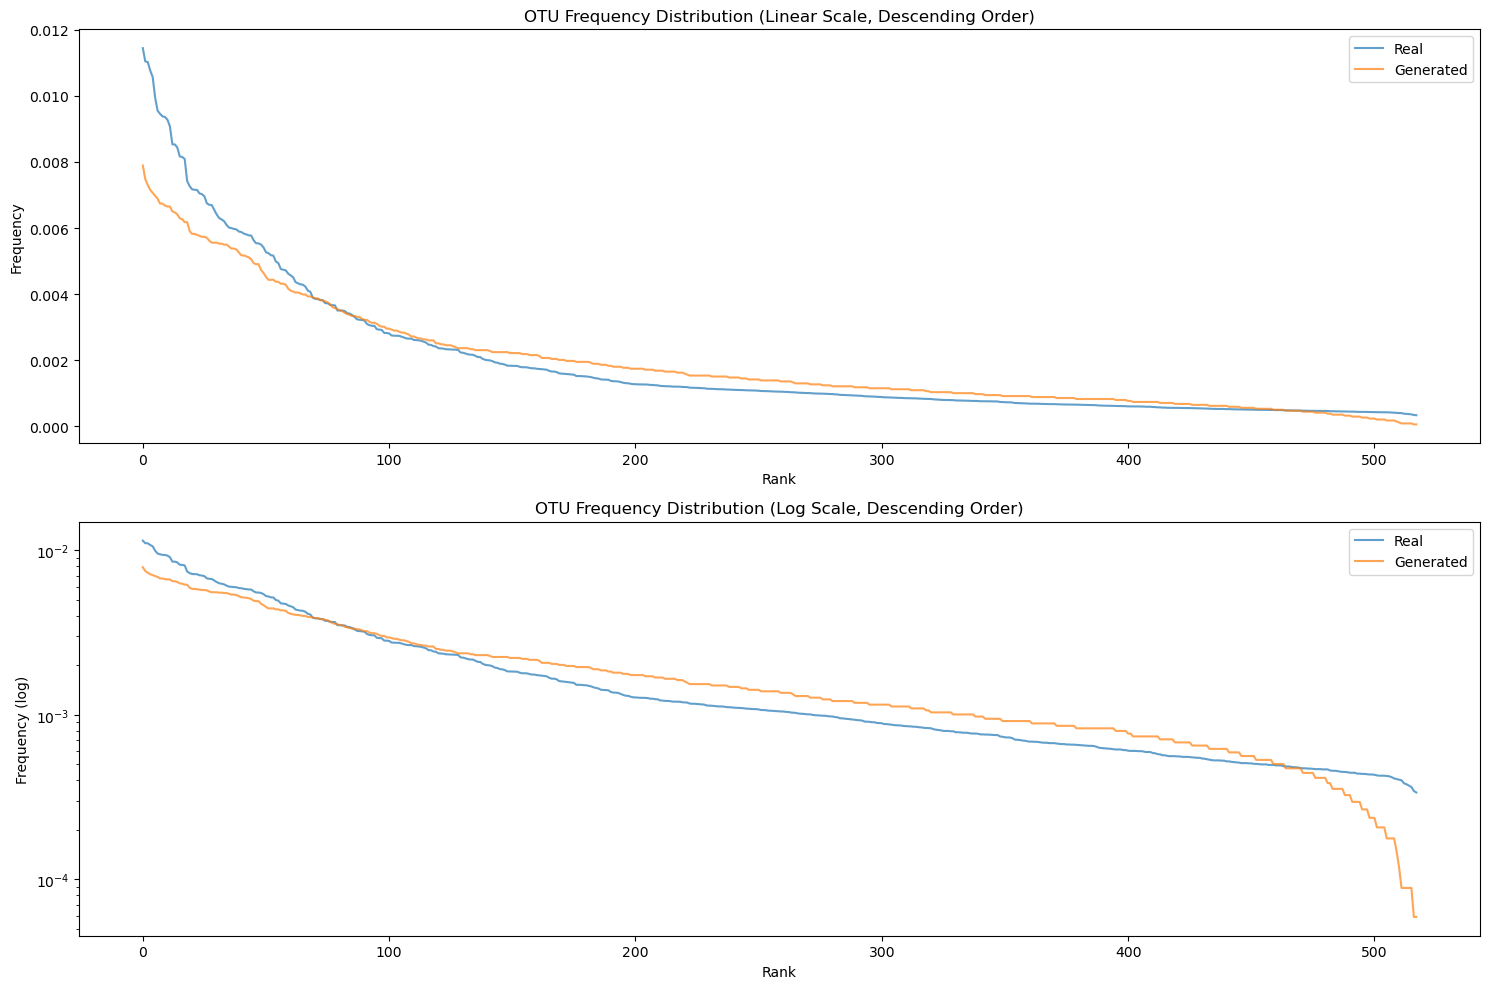

KL Divergence: 0.2013
Jensen-Shannon Divergence: 0.2177
Pearson Correlation: 0.7439

Top 20 most frequent OTUs:
Real vs Generated (OTU_ID: frequency)
Real: 206: 0.0114 | Generated: 206: 0.0079
Real: 155: 0.0110 | Generated: 155: 0.0075
Real: 147: 0.0110 | Generated: 117: 0.0073
Real: 30: 0.0108 | Generated: 58: 0.0072
Real: 207: 0.0106 | Generated: 70: 0.0071
Real: 117: 0.0099 | Generated: 80: 0.0070
Real: 203: 0.0096 | Generated: 186: 0.0069
Real: 80: 0.0095 | Generated: 147: 0.0067
Real: 99: 0.0094 | Generated: 321: 0.0067
Real: 186: 0.0094 | Generated: 30: 0.0067
Real: 193: 0.0093 | Generated: 162: 0.0067
Real: 90: 0.0091 | Generated: 104: 0.0067
Real: 278: 0.0085 | Generated: 90: 0.0065
Real: 93: 0.0085 | Generated: 193: 0.0065
Real: 140: 0.0084 | Generated: 463: 0.0064
Real: 246: 0.0082 | Generated: 19: 0.0063
Real: 58: 0.0081 | Generated: 207: 0.0063
Real: 104: 0.0081 | Generated: 99: 0.0062
Real: 132: 0.0074 | Generated: 74: 0.0062
Real: 291: 0.0073 | Generated: 158: 0.0059

Div

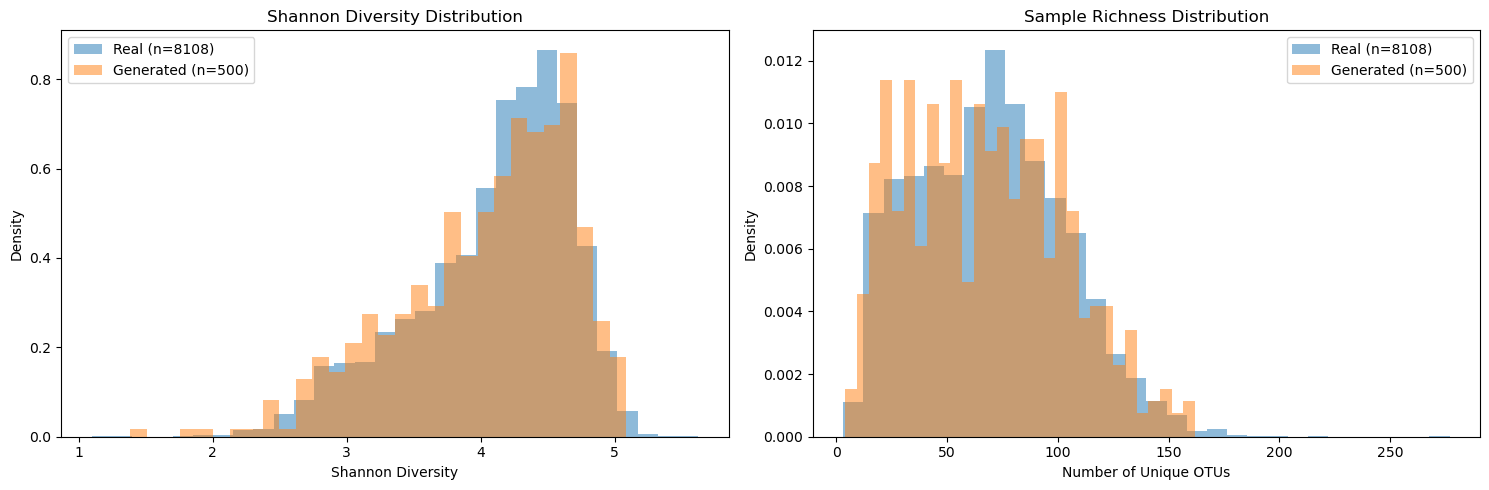

In [155]:
# Analyze distributions
vocab_size = max(max(x) for x in loaded_df['otu_arrays']) + 1
analyze_otu_distributions(loaded_df, generated_sequences, vocab_size)

In [137]:
def extended_microbiome_analysis(real_data_df, generated_sequences, num_otus):
    """Additional ecological analyses for microbiome data"""
    
    # Convert samples to presence/absence matrices
    def create_presence_matrix(samples, num_otus):
        matrix = np.zeros((len(samples), num_otus-1))  # -1 to exclude padding
        for i, sample in enumerate(samples):
            unique_otus = set(otu for otu in sample if otu != 0)
            for otu in unique_otus:
                matrix[i, otu-1] = 1
        return matrix
    
    # Get the most frequent OTUs
    def get_top_otus(samples, n=50):
        all_otus = []
        for sample in samples:
            all_otus.extend([x for x in sample if x != 0])
        counts = Counter(all_otus)
        return [otu-1 for otu, _ in counts.most_common(n)]  # -1 for zero-based indexing
    
    real_samples = [np.array([x for x in seq if x != 0]) for seq in real_data_df['otu_arrays']]
    gen_samples = [np.array([x for x in seq if x != 0]) for seq in generated_sequences]
    
    real_matrix = create_presence_matrix(real_samples, num_otus)
    gen_matrix = create_presence_matrix(gen_samples, num_otus)
    
    # Co-occurrence patterns
    real_coocur = np.corrcoef(real_matrix.T)
    gen_coocur = np.corrcoef(gen_matrix.T)
    
    # Get top OTUs indices
    top_otus = get_top_otus(real_samples)
    
    # Plot co-occurrence heatmaps
    plt.figure(figsize=(20, 8))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(real_coocur[top_otus][:, top_otus], cmap='RdBu_r', center=0)
    plt.title('Real Data Co-occurrence (top 50 most frequent OTUs)')
    
    plt.subplot(1, 2, 2)
    sns.heatmap(gen_coocur[top_otus][:, top_otus], cmap='RdBu_r', center=0)
    plt.title('Generated Data Co-occurrence (top 50 most frequent OTUs)')
    
    plt.tight_layout()
    plt.show()
    
    # Rank-abundance curves
    def get_rank_abundance(samples):
        all_otus = []
        for sample in samples:
            unique_otus = set(otu for otu in sample if otu != 0)
            all_otus.extend(unique_otus)
        counts = Counter(all_otus)
        abundances = sorted(counts.values(), reverse=True)
        return np.array(abundances) / sum(abundances)
    
    real_abundance = get_rank_abundance(real_samples)
    gen_abundance = get_rank_abundance(gen_samples)
    
    plt.figure(figsize=(10, 6))
    plt.semilogy(real_abundance, 'b-', label='Real', alpha=0.7)
    plt.semilogy(gen_abundance, 'r-', label='Generated', alpha=0.7)
    plt.xlabel('Rank')
    plt.ylabel('Relative Abundance (log scale)')
    plt.title('Rank-Abundance Curves')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Calculate and print co-occurrence similarity for top OTUs
    top_real_coocur = real_coocur[top_otus][:, top_otus]
    top_gen_coocur = gen_coocur[top_otus][:, top_otus]
    mask = ~np.isnan(top_real_coocur) & ~np.isnan(top_gen_coocur)
    coocur_correlation = np.corrcoef(top_real_coocur[mask], top_gen_coocur[mask])[0,1]
    print(f"\nCo-occurrence Pattern Correlation (top 50 OTUs): {coocur_correlation:.3f}")
    
    # Add Bray-Curtis dissimilarity
    def bray_curtis_dissimilarity(sample1, sample2):
        shared_otus = set(sample1).intersection(set(sample2))
        total_otus = set(sample1).union(set(sample2))
        if not total_otus:
            return 0
        return 1 - (2 * len(shared_otus)) / (len(set(sample1)) + len(set(sample2)))
    
    # Calculate average Bray-Curtis within each dataset
    def mean_bray_curtis(samples, max_pairs=1000):
        n = len(samples)
        pairs = min(max_pairs, n * (n-1) // 2)
        dissimilarities = []
        
        for _ in range(pairs):
            i, j = np.random.choice(n, 2, replace=False)
            bc = bray_curtis_dissimilarity(samples[i], samples[j])
            dissimilarities.append(bc)
            
        return np.mean(dissimilarities)
    
    real_bc = mean_bray_curtis(real_samples)
    gen_bc = mean_bray_curtis(gen_samples)
    
    print(f"\nMean Bray-Curtis Dissimilarity:")
    print(f"Real samples: {real_bc:.3f}")
    print(f"Generated samples: {gen_bc:.3f}")
    
def calculate_cooccurrence_correlation(sequences, num_otus, reference_coocur=None):
    """Calculate co-occurrence correlation for a set of sequences"""
    # Create presence/absence matrix
    matrix = np.zeros((len(sequences), num_otus-1))
    for i, seq in enumerate(sequences):
        unique_otus = set(otu for otu in seq if otu != 0)
        for otu in unique_otus:
            matrix[i, otu-1] = 1
    
    # Calculate co-occurrence
    coocur = np.corrcoef(matrix.T)
    
    # Get top OTUs
    all_otus = []
    for seq in sequences:
        all_otus.extend([x for x in seq if x != 0])
    counts = Counter(all_otus)
    top_otus = [otu-1 for otu, _ in counts.most_common(50)]
    
    # If reference provided, calculate correlation
    if reference_coocur is not None:
        top_coocur = coocur[top_otus][:, top_otus]
        top_ref_coocur = reference_coocur[top_otus][:, top_otus]
        
        # Flatten matrices and calculate correlation directly
        correlation = np.corrcoef(top_coocur.flatten(), top_ref_coocur.flatten())[0,1]
        return correlation
    
    return coocur

def extended_microbiome_analysis(real_data_df, generated_sequences, num_otus):
    real_samples = [np.array([x for x in seq if x != 0]) for seq in real_data_df['otu_arrays']]
    gen_samples = [np.array([x for x in seq if x != 0]) for seq in generated_sequences]
    
    # Get top OTUs
    all_otus = []
    for seq in real_samples:
        all_otus.extend([x for x in seq if x != 0])
    counts = Counter(all_otus)
    top_otus = [otu-1 for otu, _ in counts.most_common(100)]
    
    # Calculate full co-occurrence matrices
    real_coocur = calculate_cooccurrence_correlation(real_samples, num_otus)
    gen_coocur = calculate_cooccurrence_correlation(gen_samples, num_otus)
    
    # Calculate correlation score
    correlation = calculate_cooccurrence_correlation(gen_samples, num_otus, real_coocur)
    
    # Calculate RMSD for top OTUs
    real_subset = real_coocur[top_otus][:, top_otus]
    gen_subset = gen_coocur[top_otus][:, top_otus]
    rmsd = np.sqrt(np.mean((real_subset - gen_subset)**2))
    
    # Plot heatmaps
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    sns.heatmap(real_coocur[top_otus][:, top_otus], cmap='RdBu_r', center=0)
    plt.title('Real Data Co-occurrence (top 50 OTUs)')
    
    plt.subplot(1, 2, 2)
    sns.heatmap(gen_coocur[top_otus][:, top_otus], cmap='RdBu_r', center=0)
    plt.title('Generated Data Co-occurrence (top 50 OTUs)')
    plt.tight_layout()
    plt.show()
    
    print(f"\nCo-occurrence Correlation: {correlation:.3f}")
    print(f"RMSD between matrices: {rmsd:.3f}")

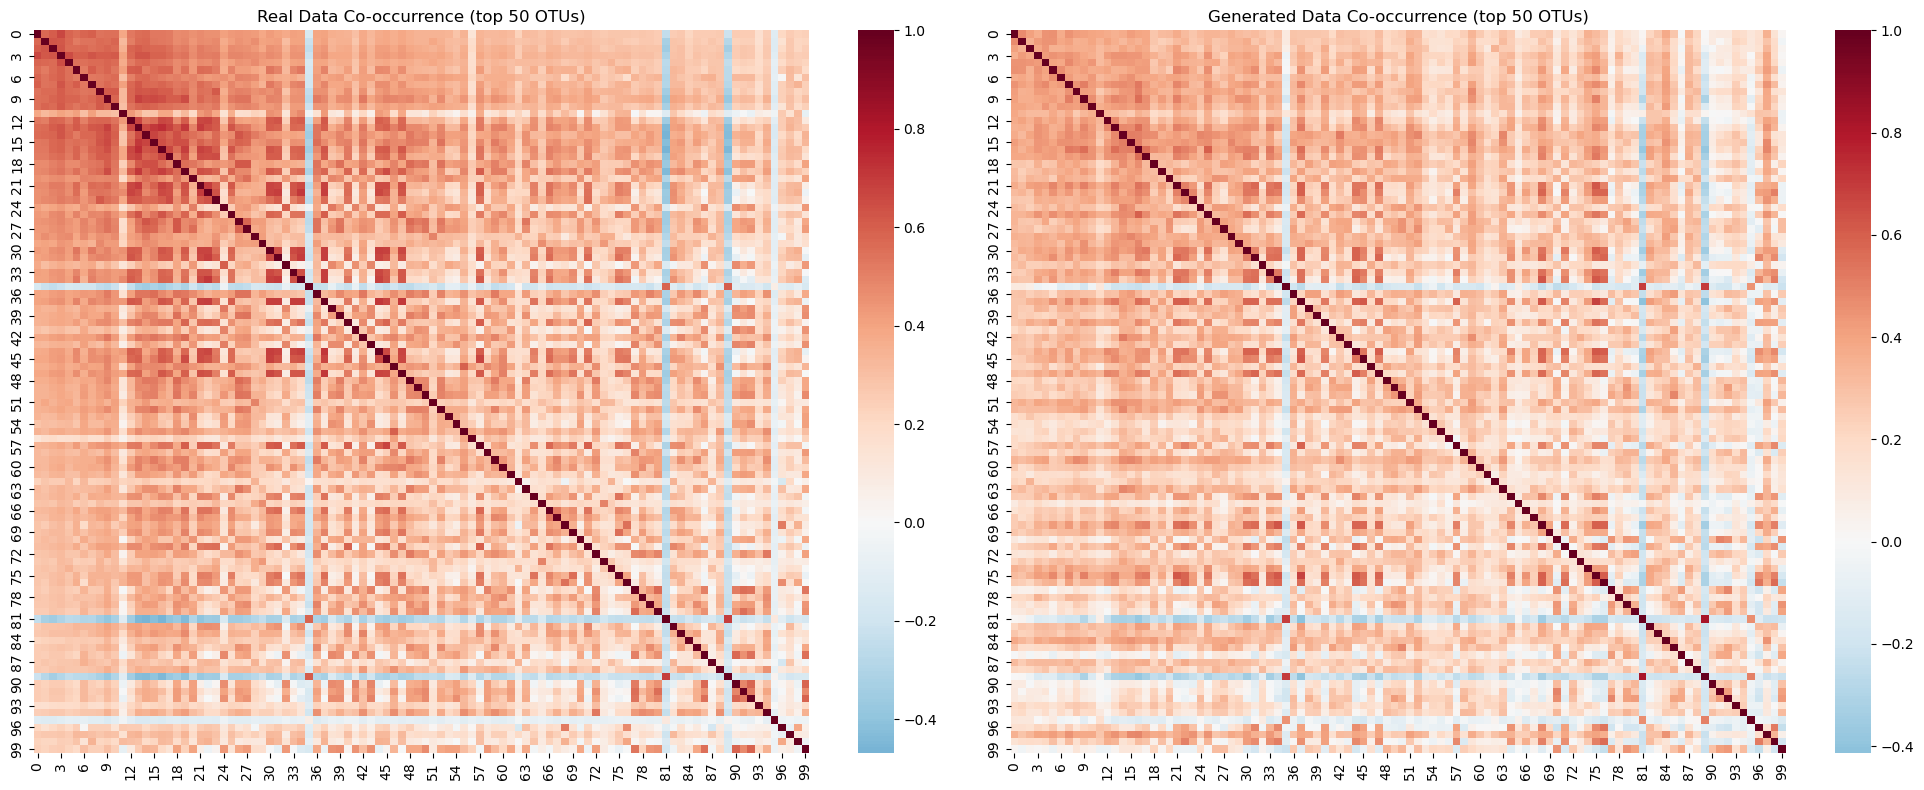


Co-occurrence Correlation: 0.624
RMSD between matrices: 0.123


In [156]:
extended_microbiome_analysis(loaded_df, generated_sequences, vocab_size) #allowing longer run time may be the main factor in this...?

In [148]:
generated_sequences[100]

array([200, 152,  73,  28,  72, 401, 363, 151,  15,  34, 102, 348, 101,
       441, 406,  33,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0])

2.79 had 0.630, 2.65 had 0.667, 2.61 had 0.597: so i have learned that the smaller model is probably lowering loss by doing well across the averaged batch by just recovering well otu frequencies independantly. but the deeper model is actually trying to model co-occurences.

In [153]:
def analyze_final_logits(model, num_sequences=10, num_steps=100,  device='cpu'):
    model.eval()
    
    # Get real lengths for sampling
    real_lengths = [len(x) for x in loaded_df['otu_arrays']]
    sampled_lengths = np.random.choice(real_lengths, size=num_sequences)
    max_sampled_length = max(sampled_lengths)

    with torch.no_grad():
        # Time steps going T -> min_t
        T = 1.0
        min_t = 0.001
        timesteps = torch.linspace(T, min_t, num_steps).to(device)
        dt = -(T-min_t)/len(timesteps)
        
        # Start with scaled noise
        torch.manual_seed(42)
        sigma_T = torch.sqrt(torch.tensor(T))
        xt = sigma_T * torch.randn(num_sequences, max_sampled_length, model.embed_dim).to(device)
        
        # Create proper padding mask
        mask = torch.zeros(num_sequences, max_sampled_length, dtype=bool).to(device)
        for i, length in enumerate(sampled_lengths):
            mask[i, length:] = True
        
        # Run diffusion
        print("\nRunning diffusion...")
        for t in tqdm(timesteps):
            t_batch = t.expand(num_sequences)
            logits = model(xt, mask, t_batch)
            expected_x0 = model.get_expected_embedding(logits)
            
            if t > min_t:
                score = (expected_x0 - xt)/(t**2)
                xt = xt - t * score * dt
        
        # Get final logits
        final_logits = model(xt, mask, torch.zeros(num_sequences).to(device))
        
        # Analyze logits for each sequence position
        print("\nAnalyzing predictions...")
        for seq_idx in range(min(3, num_sequences)):
            print(f"\nAnalyzing sequence {seq_idx + 1} (length {sampled_lengths[seq_idx]}):")
            for pos in range(min(5, sampled_lengths[seq_idx])):
                logits = final_logits[seq_idx, pos]
                
                # Mask padding token (assuming 0 is padding)
                logits[0] = float('-inf')
                probs = F.softmax(logits, dim=-1)
                
                # Get top 5 predictions
                top_probs, top_indices = torch.topk(probs, 5)
                print(f"\nPosition {pos}:")
                print("Top 5 predictions (OTU: probability):")
                for idx, prob in zip(top_indices, top_probs):
                    print(f"OTU {idx.item()}: {prob.item():.4f}")
                
                # Calculate entropy of distribution
                entropy = -torch.sum(probs * torch.log2(probs + 1e-10))  # using log base 2 for more interpretable entropy
                print(f"Distribution entropy (bits): {entropy.item():.4f}")

# Run analysis
analyze_final_logits(model0, num_steps=20)


Running diffusion...


100%|██████████| 20/20 [00:00<00:00, 67.92it/s]



Analyzing predictions...

Analyzing sequence 1 (length 142):

Position 0:
Top 5 predictions (OTU: probability):
OTU 250: 0.9998
OTU 105: 0.0000
OTU 490: 0.0000
OTU 359: 0.0000
OTU 126: 0.0000
Distribution entropy (bits): 0.0028

Position 1:
Top 5 predictions (OTU: probability):
OTU 158: 0.9937
OTU 452: 0.0056
OTU 70: 0.0002
OTU 504: 0.0002
OTU 174: 0.0001
Distribution entropy (bits): 0.0608

Position 2:
Top 5 predictions (OTU: probability):
OTU 296: 0.9957
OTU 493: 0.0010
OTU 183: 0.0005
OTU 324: 0.0005
OTU 245: 0.0004
Distribution entropy (bits): 0.0571

Position 3:
Top 5 predictions (OTU: probability):
OTU 58: 0.9993
OTU 107: 0.0006
OTU 471: 0.0000
OTU 93: 0.0000
OTU 248: 0.0000
Distribution entropy (bits): 0.0091

Position 4:
Top 5 predictions (OTU: probability):
OTU 468: 0.9993
OTU 517: 0.0001
OTU 478: 0.0001
OTU 400: 0.0001
OTU 333: 0.0001
Distribution entropy (bits): 0.0115

Analyzing sequence 2 (length 48):

Position 0:
Top 5 predictions (OTU: probability):
OTU 68: 0.9708
OTU 3

In [160]:
def analyze_step_impact(model, step_counts=[5, 20, 50, 100], num_sequences=100, device='cpu'):
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    results = {}
    
    # Run diffusion with different step counts
    for num_steps in step_counts:
        model.eval()
        
        # Get real lengths for sampling
        real_lengths = [len(x) for x in loaded_df['otu_arrays']]
        sampled_lengths = np.random.choice(real_lengths, size=num_sequences)
        max_sampled_length = max(sampled_lengths)

        with torch.no_grad():
            T = 1.0
            min_t = 0.001
            timesteps = torch.linspace(T, min_t, num_steps).to(device)
            dt = -(T-min_t)/len(timesteps)
            
            # Use same seed for fair comparison
            torch.manual_seed(42)
            sigma_T = torch.sqrt(torch.tensor(T))
            xt = sigma_T * torch.randn(num_sequences, max_sampled_length, model.embed_dim).to(device)
            
            mask = torch.zeros(num_sequences, max_sampled_length, dtype=bool).to(device)
            for i, length in enumerate(sampled_lengths):
                mask[i, length:] = True
            
            # Run diffusion
            for t in timesteps:
                t_batch = t.expand(num_sequences)
                logits = model(xt, mask, t_batch)
                expected_x0 = model.get_expected_embedding(logits)
                
                if t > min_t:
                    score = (expected_x0 - xt)/(t**2)
                    xt = xt - t * score * dt
            
            final_logits = model(xt, mask, torch.zeros(num_sequences).to(device))
            
            # Store results
            results[num_steps] = {
                'entropies': [],
                'top_probs': []
            }
            
            # Calculate metrics for each sequence
            for seq_idx in range(num_sequences):
                for pos in range(min(5, sampled_lengths[seq_idx])):
                    logits = final_logits[seq_idx, pos]
                    logits[0] = float('-inf')  # mask padding token
                    probs = F.softmax(logits, dim=-1)
                    
                    # Calculate entropy
                    entropy = -torch.sum(probs * torch.log2(probs + 1e-10))
                    results[num_steps]['entropies'].append(entropy.item())
                    
                    # Get top probability
                    top_prob = torch.max(probs).item()
                    results[num_steps]['top_probs'].append(top_prob)

    # Create plotly figure with subplots
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Distribution Entropy vs Steps', 'Top Prediction Probability vs Steps'),
        horizontal_spacing=0.1
    )

    # Add box plots for entropy
    fig.add_trace(
        go.Box(
            y=[val for val in results[step_counts[0]]['entropies']],
            name=str(step_counts[0]),
            boxpoints='outliers',
            line_color='blue'
        ),
        row=1, col=1
    )

    for step in step_counts[1:]:
        fig.add_trace(
            go.Box(
                y=[val for val in results[step]['entropies']],
                name=str(step),
                boxpoints='outliers',
                line_color='blue'
            ),
            row=1, col=1
        )

    # Add box plots for top probabilities
    fig.add_trace(
        go.Box(
            y=[val for val in results[step_counts[0]]['top_probs']],
            name=str(step_counts[0]),
            boxpoints='outliers',
            line_color='red'
        ),
        row=1, col=2
    )

    for step in step_counts[1:]:
        fig.add_trace(
            go.Box(
                y=[val for val in results[step]['top_probs']],
                name=str(step),
                boxpoints='outliers',
                line_color='red'
            ),
            row=1, col=2
        )

    # Update layout
    fig.update_layout(
        title_text="Impact of Diffusion Steps on Prediction Characteristics",
        showlegend=False,
        width=1200,
        height=600,
        template='plotly_white'
    )

    # Update axes labels
    fig.update_xaxes(title_text="Number of Steps", row=1, col=1)
    fig.update_xaxes(title_text="Number of Steps", row=1, col=2)
    fig.update_yaxes(title_text="Distribution Entropy (bits)", row=1, col=1)
    fig.update_yaxes(title_text="Top Prediction Probability", row=1, col=2)

    # Show the plot
    fig.show()

    # Add summary statistics
    print("\nSummary Statistics:")
    for steps in step_counts:
        mean_entropy = np.mean(results[steps]['entropies'])
        mean_prob = np.mean(results[steps]['top_probs'])
        print(f"\nSteps: {steps}")
        print(f"Average Entropy: {mean_entropy:.4f} bits")
        print(f"Average Top Probability: {mean_prob:.4f}")

    return results, fig

# Run analysis
results, fig = analyze_step_impact(model0)


Summary Statistics:

Steps: 5
Average Entropy: 1.9698 bits
Average Top Probability: 0.5978

Steps: 20
Average Entropy: 1.0023 bits
Average Top Probability: 0.8124

Steps: 50
Average Entropy: 0.5858 bits
Average Top Probability: 0.9027

Steps: 100
Average Entropy: 0.5656 bits
Average Top Probability: 0.9096


In [198]:
generated_sequences_umap = generate_sequences(model0, num_sequences=500, temperature=1, num_steps=30)
#It seems that both num sequences and num steps together have an effect. im not sure on the combined function that imroves (could increasing one require
#increase in the other?)
"""
250,10 recovers 6-7 clusters
500,5 recovers 4
500,10 recovers 4-5
500,15 r 4
500,20 recovers 4-5
500,30 r 5 but stringy and unnatural looking, not clumpy
"""

Starting denoising process...


0it [00:00, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


1it [00:00,  4.16it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2it [00:00,  4.41it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


3it [00:00,  4.45it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


4it [00:00,  4.23it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


5it [00:01,  4.16it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


6it [00:01,  3.95it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


7it [00:01,  3.73it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


8it [00:02,  3.70it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


9it [00:02,  3.81it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


10it [00:02,  4.04it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


11it [00:02,  4.09it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


12it [00:02,  4.14it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


13it [00:03,  4.22it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


14it [00:03,  4.23it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


15it [00:03,  4.26it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


16it [00:03,  4.25it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


17it [00:04,  4.33it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


18it [00:04,  4.16it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


19it [00:04,  4.11it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


20it [00:04,  4.21it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


21it [00:05,  4.30it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


22it [00:05,  4.30it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


23it [00:05,  4.31it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


24it [00:05,  4.27it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


25it [00:06,  4.05it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


26it [00:06,  4.15it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


27it [00:06,  4.30it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


28it [00:06,  4.41it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


29it [00:06,  4.31it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


30it [00:07,  4.18it/s]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


'\n250,10 recovers 6-7 clusters\n500,5 recovers 4\n500,10 recovers 4-5\n500,15 r 4\n500,20 recovers 4-5\n'

Converting to binary vectors...
Performing UMAP reduction...


/Users/matteo/anaconda3/envs/matlas/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/matteo/anaconda3/envs/matlas/lib/python3.11/site-packages/umap/umap_.py:1887: UserWarning:

gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable

/Users/matteo/anaconda3/envs/matlas/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



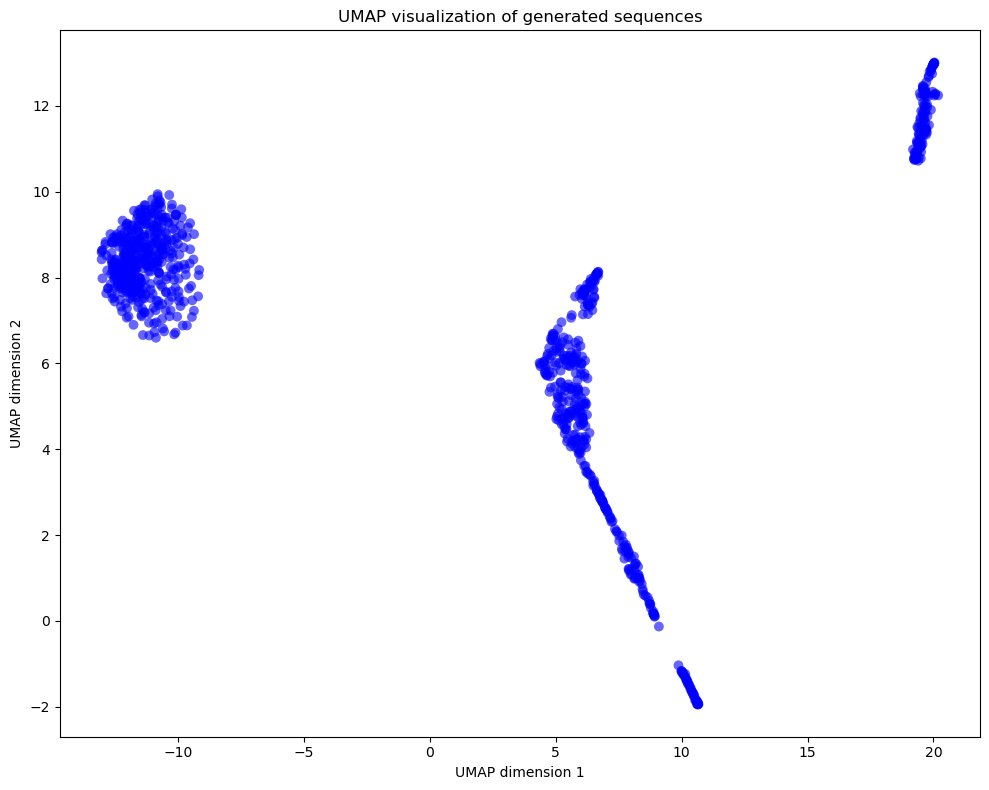


Sequence statistics:
Average sequence length: 67.66
Number of unique tokens used: 519


In [199]:
import umap
import numpy as np
np.random.seed(42)
import random
random.seed(42)

# Convert sequences to binary vectors
print("Converting to binary vectors...")

# First, determine the vocabulary size (number of unique tokens)
vocab_size = 519  # Adjust this if your vocab size is different

# Initialize array to hold binary vectors
binary_vectors = np.zeros((1000, vocab_size))

# Convert each sequence to binary vector
for i, seq in enumerate(generated_sequences_umap):
    # Create binary vector where 1 indicates presence of token
    unique_tokens = np.unique(seq[seq != 0])  # Ignore padding tokens (0)
    binary_vectors[i, unique_tokens] = 1

# Reduce dimensionality with UMAP
print("Performing UMAP reduction...")
reducer = umap.UMAP(
    n_neighbors=10,
    min_dist=0.1,
    n_components=2,
    random_state=42,
    metric = 'jaccard'
)
embedding = reducer.fit_transform(binary_vectors)

# Create scatter plot
# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], 
           alpha=0.6,           # Adjust transparency
           s=50,               # Point
           c='blue',          # Point color
           edgecolor='none')  # No edge color for cleaner look

plt.title('UMAP visualization of generated sequences')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')

plt.tight_layout()
plt.show()

# Print some statistics
print("\nSequence statistics:")
print(f"Average sequence length: {np.mean([len(seq[seq != 0]) for seq in generated_sequences]):.2f}")
print(f"Number of unique tokens used: {len(np.unique(generated_sequences))}")